In [1]:
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist


import matplotlib.pyplot as plt
import seaborn as sns


## 1. Predicting Young modulus as a linear regression problem   

Since $Y = - \frac{il}{2kl\sqrt{Bm'}}$ and having the experimental data. The first approach is to predict the Young's modulus value as a simple regression problem      

In [2]:
beam = {"length": 0.301,
        "width": 0.026,
        "thickness": 0.003,
        
        "E": 10e10,
        
        "mass": 0.1877
       }

beam["massPerUnit"] = beam["mass"] / beam["length"]
beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
beam["I"] = beam["width"]*beam["thickness"]**3/12


In [4]:
def mobilityFunc(E, kl, beam=beam, eta=0.1):
    l = beam["length"]
    
    N_l = np.cos(kl)*np.cosh(kl) + 1
    D_l = np.cos(kl)*np.sinh(kl) + np.sin(kl)*np.cosh(kl)
    B = E*beam["I"]
    Y = -(1j*l/ 2*kl)*(1-1j*eta/4)*l*np.sqrt(B*(1+1j*eta)*beam["massPerUnit"]) * N_l/D_l
    return Y

/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


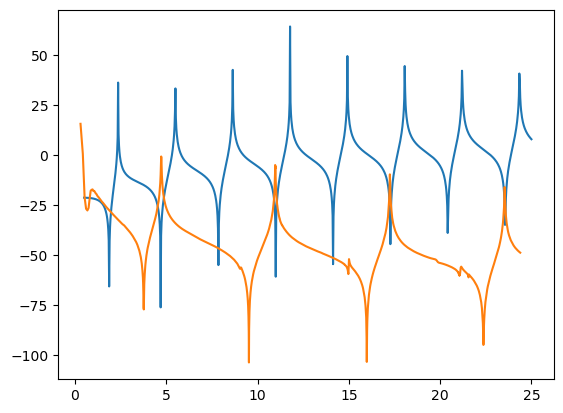

In [33]:
kl = np.linspace(0.5, 25, 1000)
Y = mobilityFunc(10e10, kl, beam)
plt.plot(kl, 20*np.log10(Y))
w = 2*np.pi*data["freq"]
B = beam["E"]*beam["I"]
cb = np.sqrt(w)*(B/beam["massPerUnit"])**(1/4)
kl_data = w/cb * (1-1j*(0.0007/4))*beam["length"]
plt.plot(kl_data, 20*np.log10(data["mobility"]))

/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


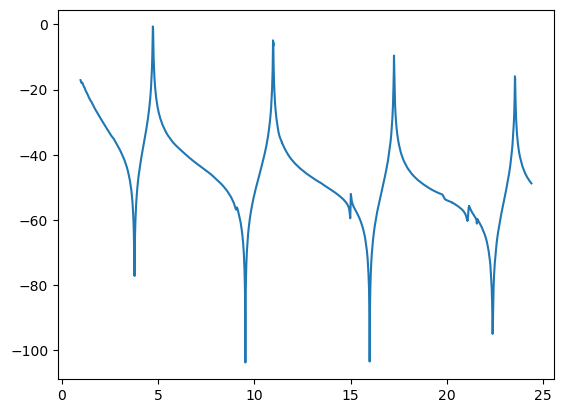

In [34]:
data = pd.read_csv("./Data/bend/centerFreqResponse.csv")[10:]
data["mobility"] = data["force"] + 1j*data["velocity"]

w = 2*np.pi*data["freq"]
B = beam["E"]*beam["I"]
cb = np.sqrt(w)*(B/beam["massPerUnit"])**(1/4)
kl_data = w/cb * (1-1j*(0.0007/4))*beam["length"]

plt.plot(kl_data, 20*np.log10(data["mobility"]))

In [83]:
def mobilityFuncModel(E, freq, beam=beam, eta=0.001):
    l = beam["length"]
    
    E = E.numpy()
    print(E)
    freq = freq
    B = E*beam["I"]
    w = 2*np.pi*freq
    cb = np.sqrt(w)*(B/beam["massPerUnit"])**(1/4)
    kl = w/cb * (1-1j*(eta/4))*beam["length"]
    
    N_l = np.cos(kl)*np.cosh(kl) + 1
    D_l = np.cos(kl)*np.sinh(kl) + np.sin(kl)*np.cosh(kl)
    
    
    Y = -(1j*l/ 2*kl)*(1-1j*eta/4)*l*np.sqrt(B*(1+1j*eta)*beam["massPerUnit"]) * N_l/D_l
    return Y

In [88]:
def model(freq, Y_exp):
    E_theo = 10e10 # theoreticall Young's modulus of brass
    #alpha = pyro.sample("alpha", dist.Normal(Etheo, 1))
    #beta = pyro.sample("beta", dist.Dirichlet(10))
    E = pyro.sample("E", dist.Normal(E_theo, 1.))
    with pyro.plate("data", len(freq)):
        Y = pyro.sample("Y", dist.Normal(mobilityFuncModel(E, freq), 1.), obs=Y_exp)
    return Y
         

In [89]:
from pyro.infer import MCMC, NUTS
import torch
#y_obs = torch.tensor(np.array(data["mobility"])) # Suppose this was the vector of observed y's
#freq = torch.tensor(np.array(data["freq"])).float()
y_obs = np.array(data["mobility"]) # Suppose this was the vector of observed y's
freq = np.array(data["freq"])
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=1)
mcmc.run(freq)#, y_obs)

# Show summary of inference results
mcmc.summary()

Warmup:   0%|          | 0/1500 [00:00, ?it/s]

100000000000.0


ValueError: Input arguments must all be instances of numbers.Number, torch.Tensor or objects implementing __torch_function__.
Trace Shapes:       
 Param Sites:       
Sample Sites:       
       E dist      |
        value      |
    data dist      |
        value 6391 |